In [17]:
import math
import torch
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn.init as init

class GNNLayer(Module):
    def __init__(self, in_features, out_features):
        super(GNNLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        torch.nn.init.xavier_uniform_(self.weight)
        # init.kaiming_uniform_(self.weight, nonlinearity='relu')

    def forward(self, features, adj, active=True):
        support = torch.mm(features, self.weight)
        output = torch.mm(adj, support)
        if active:
            output = F.relu(output)
        return output

In [18]:
import numpy as np
import scipy.sparse as sp
import scipy.io as sio
import torch
from torch.utils.data import Dataset
from sklearn.metrics import pairwise_distances as pair
from sklearn.neighbors import NearestNeighbors
import torch.nn.functional as F



class load_data(Dataset):
    def __init__(self, dataset, label):
        self.x = dataset
        self.y = label
        # data_mat.close()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), \
            torch.from_numpy(np.array(self.y[idx]))

X.shape= (220, 21025)
DTFU(
  (ael): AE(
    (enc_1): Linear(in_features=21025, out_features=512, bias=True)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_2): Linear(in_features=512, out_features=256, bias=True)
    (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_3): Linear(in_features=256, out_features=128, bias=True)
    (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (z_layer): Linear(in_features=128, out_features=64, bias=True)
    (dec_1): Linear(in_features=64, out_features=128, bias=True)
    (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec_2): Linear(in_features=128, out_features=256, bias=True)
    (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec_3): Linear(in_features=256, out_features=512, bias=True)
    (bn6): BatchNorm1d(512, eps=1e-

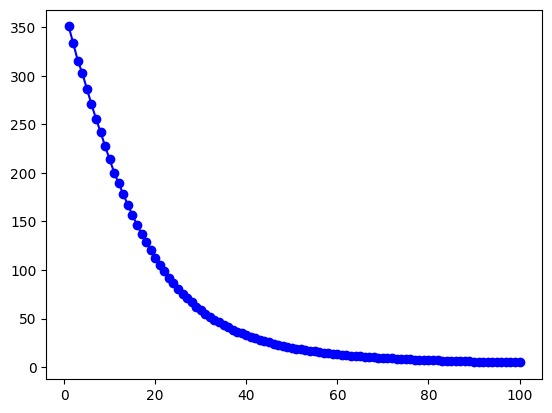

In [19]:
from __future__ import print_function, division
import argparse
import random
import numpy as np
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import Linear
import scipy.sparse as sp
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import dia_matrix, issparse
from sklearn.preprocessing import StandardScaler
import torch.nn.init as init


# torch.cuda.set_device(1)

class AttentionLayer(nn.Module):
    def __init__(self, last_dim, n_num):
        super(AttentionLayer, self).__init__()
        self.n_num = n_num
        self.fc1 = nn.Linear(n_num * last_dim, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, n_num)
        self.attention = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.T = 10
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        attention_sample = self.attention(x / self.T)
        attention_view = torch.mean(attention_sample, dim=0, keepdim=True).squeeze()
        return attention_view


class FusionLayer(nn.Module):
    def __init__(self, last_dim, n_num=2):
        super(FusionLayer, self).__init__()
        self.n_num = n_num
        self.attentionLayer = AttentionLayer(last_dim, n_num)

    def forward(self, x, k):
        y = torch.cat((x, k), 1)
        weights = self.attentionLayer(y)
        x_TMP = weights[0] * x + weights[1] * k
        return x_TMP


def distance(X, Y, square=True):
    """
    Compute Euclidean distances between two sets of samples
    Basic framework: pytorch
    :param X: d * n, where d is dimensions and n is number of data points in X
    :param Y: d * m, where m is number of data points in Y
    :param square: whether distances are squared, default value is True
    :return: n * m, distance matrix
    """
    n = X.shape[1]
    m = Y.shape[1]
    x = torch.norm(X, dim=0)
    x = x * x  # n * 1
    x = torch.t(x.repeat(m, 1))

    y = torch.norm(Y, dim=0)
    y = y * y  # m * 1
    y = y.repeat(n, 1)

    crossing_term = torch.t(X).matmul(Y)
    result = x + y - 2 * crossing_term
    result = result.relu()
    if not square:
        result = torch.sqrt(result)
    return result
    
def cal_weights_via_CAN(X, num_neighbors, links=0):
    """
    Solve Problem: Clustering-with-Adaptive-Neighbors(CAN)
    :param X: d * n
    :param num_neighbors:
    :return:
    """
    size = X.shape[1]
    distances = distance(X, X)
    distances = torch.max(distances, torch.t(distances))
    sorted_distances, _ = distances.sort(dim=1)
    top_k = sorted_distances[:, num_neighbors + 1] # top_k = sorted_distances[:, num_neighbors]
    top_k = torch.t(top_k.repeat(size, 1)) + 10**-10

    sum_top_k = torch.sum(sorted_distances[:, 1:num_neighbors+1], dim=1)  # sum_top_k = torch.sum(sorted_distances[:, 0:num_neighbors], dim=1)
    sum_top_k = torch.t(sum_top_k.repeat(size, 1))
    sorted_distances = None
    torch.cuda.empty_cache()
    T = top_k - distances
    distances = None
    torch.cuda.empty_cache()
    weights = torch.div(T, num_neighbors * top_k - sum_top_k)
    T = None
    top_k = None
    sum_top_k = None
    torch.cuda.empty_cache()
    weights = weights.relu().cpu()
    weights -= torch.diag(torch.diag(weights))
    if links != 0:
        links = torch.Tensor(links).cuda()
        weights += torch.eye(size).cuda()
        weights += links
        weights /= weights.sum(dim=1).reshape([size, 1])
    torch.cuda.empty_cache()
    raw_weights = weights
    weights = (weights + weights.t()) / 2
    raw_weights = raw_weights.cuda()
    weights = weights.cuda()
    return weights, raw_weights

def spatial_similarity(X,k):
    """
    根据特征矩阵X构建k近邻空间矩阵
    :param X: d x n 特征矩阵，d为维度，n为样本数量
    :param k: 选择的近邻数量
    :return: n x n 的矩阵
    """
    n = X.shape[1]
    
    # 计算所有样本间的平方距离矩阵（n x n）
    distance_matrix = distance(X, X, square=True)
    
    # 对每行距离排序，获取排序后的索引（排除自身）
    _, sorted_indices = torch.sort(distance_matrix, dim=1)  # sorted_indices形状为[n, n]
    
    # 提取每个样本的k近邻索引（跳过第0个自身）
    knn_indices = sorted_indices[:, :k+1]  # 形状变为[n, k+1]
    
     # 创建全零矩阵
    A = torch.zeros((n, n), dtype=torch.long).cuda()
    
    # 生成行索引矩阵
    row_indices = torch.arange(n).unsqueeze(1).expand(n, k+1).cuda()
    
    # 计算绝对差值并填充
    abs_diffs = torch.abs(row_indices - knn_indices)
    A[row_indices, knn_indices] = abs_diffs

    row_sums = A.sum(dim=1)
    sigma = row_sums / (k+1)
    
    # 使用计算出来的sigma更新矩阵
    spa_matrix = torch.exp(-A / (2 * sigma ** 2))
    
    return spa_matrix
    
def dot_product(z,k):
    distances = distance(z.t(), z.t())
    softmax = torch.nn.Softmax(dim=1)
    adj1 = softmax(-distances)
    adj1 = adj1 * spatial_similarity(z.t(),k)
    return adj1


def normalize(mx):
    rowsum = mx.sum(1)
    r_inv_sqrt = torch.pow(rowsum, -0.5).flatten()
    r_inv_sqrt[torch.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = torch.diag(r_inv_sqrt)
    mx = torch.matmul(mx, r_mat_inv_sqrt)
    mx = torch.transpose(mx, 0, 1)
    mx = torch.matmul(mx, r_mat_inv_sqrt)
    return mx


class AE(nn.Module):

    def __init__(self, n_enc_1, n_enc_2, n_enc_3, n_dec_1, n_dec_2, n_dec_3,
                 n_input, n_z):
        super(AE, self).__init__()
        # Encoder Layers
        self.enc_1 = Linear(n_input, n_enc_1)
        self.bn1 = nn.BatchNorm1d(n_enc_1)  # BatchNorm after Linear
        self.enc_2 = Linear(n_enc_1, n_enc_2)
        self.bn2 = nn.BatchNorm1d(n_enc_2)
        self.enc_3 = Linear(n_enc_2, n_enc_3)
        self.bn3 = nn.BatchNorm1d(n_enc_3)
        self.z_layer = Linear(n_enc_3, n_z)

        # Decoder Layers
        self.dec_1 = Linear(n_z, n_dec_1)
        self.bn4 = nn.BatchNorm1d(n_dec_1)
        self.dec_2 = Linear(n_dec_1, n_dec_2)
        self.bn5 = nn.BatchNorm1d(n_dec_2)
        self.dec_3 = Linear(n_dec_2, n_dec_3)
        self.bn6 = nn.BatchNorm1d(n_dec_3)
        self.x_bar_layer = Linear(n_dec_3, n_input)

    def forward(self, x):
        # Encoder: Linear + BatchNorm + ReLU
        enc_h1 = F.relu(self.bn1(self.enc_1(x)))
        enc_h2 = F.relu(self.bn2(self.enc_2(enc_h1)))
        enc_h3 = F.relu(self.bn3(self.enc_3(enc_h2)))
        z = self.z_layer(enc_h3)

        # Decoder: Linear + BatchNorm + ReLU
        dec_h1 = F.relu(self.bn4(self.dec_1(z)))
        dec_h2 = F.relu(self.bn5(self.dec_2(dec_h1)))
        dec_h3 = F.relu(self.bn6(self.dec_3(dec_h2)))
        x_bar = self.x_bar_layer(dec_h3)

        return x_bar, enc_h1, enc_h2, enc_h3, z, dec_h1, dec_h2, dec_h3


class DTFU(nn.Module):

    def __init__(self, n_enc_1, n_enc_2, n_enc_3, n_dec_1, n_dec_2, n_dec_3,
                 n_input, n_z, pretrain_path, k, num_bands):
        super(DTFU, self).__init__()

        # autoencoder for intra information
        self.ael = AE(
            n_enc_1=n_enc_1,
            n_enc_2=n_enc_2,
            n_enc_3=n_enc_3,
            n_dec_1=n_dec_1,
            n_dec_2=n_dec_2,
            n_dec_3=n_dec_3,
            n_input=n_input,
            n_z=n_z)

        # self.ael.load_state_dict(torch.load(pretrain_path, map_location='cpu'))

        # GCN for inter information
        self.gnn_1 = GNNLayer(n_input, n_enc_1)
        self.gnn_2 = GNNLayer(n_enc_1, n_enc_2)
        self.gnn_3 = GNNLayer(n_enc_2, n_enc_3)
        self.gnn_4 = GNNLayer(n_enc_3, n_z)
        self.gnn_5 = GNNLayer(n_z, n_dec_1)

        self.gnn_7 = GNNLayer(n_dec_1, n_dec_2)
        self.gnn_8 = GNNLayer(n_dec_2, n_dec_3)
        self.gnn_9 = GNNLayer(n_dec_3, n_input)
        
        self.fuse1 = FusionLayer(n_enc_1)
        self.fuse2 = FusionLayer(n_enc_2)
        self.fuse3 = FusionLayer(n_enc_3)
        self.fuse4 = FusionLayer(n_z)

        self.fuse5 = FusionLayer(n_dec_1)
        self.fuse6 = FusionLayer(n_dec_2)
        self.fuse7 = FusionLayer(n_dec_3)
        self.fuse8 = FusionLayer(n_input)

        # degree
        self.k = k
        self.num_bands = num_bands

    def forward(self, x, adj):
        # DNN Module
        x_bar, tra1, tra2, tra3, z, dec_1, dec_2, dec_3 = self.ael(x)

        sigma = 0.2

        # GCN Module
        h = self.gnn_1(x, adj)
        h = self.fuse1(h, tra1)
        adj1 = dot_product(h,self.k)
        adj1= (1 - sigma) * adj1 + sigma * adj
        adj1_f = adj1.detach().cpu().numpy().astype(float)
        sio.savemat('A1',{'a1':adj1_f})
        adj1 = get_Laplacian_from_weights(adj1)   #归一化
        
        h = self.gnn_2(h, adj1)
        h = self.fuse2(h, tra2)
        adj2 = dot_product(h,self.k)
        adj2= (1 - sigma) * adj2 + sigma * adj
        adj2_f = adj2.detach().cpu().numpy().astype(float)
        sio.savemat('A2',{'a2':adj2_f})
        adj2 = get_Laplacian_from_weights(adj2)

        
        h = self.gnn_3(h, adj2)
        h = self.fuse3(h, tra3)
        adj3 = dot_product(h,self.k)
        adj3= (1 - sigma) * adj3 + sigma * adj
        adj3_f = adj3.detach().cpu().numpy().astype(float)
        sio.savemat('A3',{'a3':adj3_f})
        adj3 = get_Laplacian_from_weights(adj3)
        

        h = self.gnn_4(h, adj3)
        h = self.fuse4(h, z)
        adj4 = dot_product(h,self.k)
        adj4= (1 - sigma) * adj4 + sigma * adj
        adj4_f = adj4.detach().cpu().numpy().astype(float)
        sio.savemat('A4',{'a4':adj4_f})
        adj4 = get_Laplacian_from_weights(adj4)


        h1 = h
        h = self.gnn_5(h, adj4)
        h = self.fuse5(h, dec_1)
        adj5 = dot_product(h,self.k)
        adj5= (1 - sigma) * adj5 + sigma * adj
        adj5_f = adj5.detach().cpu().numpy().astype(float)
        sio.savemat('A5',{'a5':adj5_f})
        adj5 = get_Laplacian_from_weights(adj5)

        h = self.gnn_7(h, adj5)
        h = self.fuse6(h, dec_2)
        adj6 = dot_product(h,self.k)
        adj6= (1 - sigma) * adj6 + sigma * adj
        adj6_f = adj6.detach().cpu().numpy().astype(float)
        sio.savemat('A6',{'a6':adj6_f})
        adj6 = get_Laplacian_from_weights(adj6)
        

        h = self.gnn_8(h, adj6)
        h = self.fuse7(h, dec_3)
        adj7 = dot_product(h,self.k)
        adj7= (1 - sigma) * adj7 + sigma * adj
        adj7_f = adj7.detach().cpu().numpy().astype(float)
        sio.savemat('A7',{'a7':adj7_f})
        adj7 = get_Laplacian_from_weights(adj7)

        h = self.gnn_9(h, adj7)
        h = self.fuse8(h, x_bar)
        A_pred = dot_product(h,self.k)
        A_pred = (1 - sigma) * A_pred + sigma * adj

        return x_bar, z, A_pred, h, h1



def get_Laplacian_from_weights(weights):
    degree = torch.sum(weights, dim=1).pow(-0.5)
    return (weights * degree).t()*degree

def check_gradients(model):
    """
    Checks if any of the gradients are NaN, Inf
    """
    for param in model.parameters():
        if param.grad is not None:
            # Check if the gradients contain NaN or Inf
            if torch.isnan(param.grad).any():
                print(f"NaN detected in gradient for parameter {param}")
            if torch.isinf(param.grad).any():
                print(f"Inf detected in gradient for parameter {param}")



def train_dtfu(dataset, n_input, n_z, lr, name, k, epoches, pretrain_path, lamb_da):
    num = dataset.x.shape[0]
    model = DTFU(512, 256, 128, 128, 256, 512,
                 n_input=n_input,
                 n_z=n_z,
                 pretrain_path = pretrain_path, k=k, num_bands = num).to(device)
    print(model)

    optimizer = Adam(model.parameters(), lr=lr)

    # KNN Graph
    data = torch.Tensor(dataset.x).to(device)
    weights, raw_weights = cal_weights_via_CAN(data.t(), k)
    
    weights_spectral = weights.detach().cpu().numpy().astype(float)
    
    spatial_matrix = spatial_similarity(data.t(),k)
    weights_spatial = spatial_matrix.detach().cpu().numpy().astype(float)
    
    weights = weights * spatial_matrix
    weights_f = weights.detach().cpu().numpy().astype(float)
    
    L = get_Laplacian_from_weights(weights)
    L_f = L.detach().cpu().numpy().astype(float)
    
    print("completed!")
    
    losses = []
    for epoch in range(epoches):

        x_bar,z, A_pred, Z, Z_ = model(data,L)

        re_loss = F.mse_loss(x_bar, data)
        re_graphloss = torch.sum(weights * torch.log(weights / (A_pred+10**-10) + 10**-10))
        re_graphloss = re_graphloss / num

        loss = lamb_da[1] * re_loss + lamb_da[0] * re_graphloss 
        losses.append(loss.item())
        print('{} loss: {}, re_loss:{},re_graphloss:{}'.format(epoch, loss.item(),re_loss.item(),re_graphloss.item()))
        optimizer.zero_grad()
        loss.backward()
        check_gradients(model)
        optimizer.step()
    return A_pred, Z_, Z, losses


if __name__ == "__main__":

    # name = 'DC191'
    name = 'IP220'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Original_Img = sio.loadmat('data/DC_Sub.mat')['DC_Sub']
    Original_Img = sio.loadmat('datasets/Indian_pines.mat')['indian_pines']
    new_l = []
    c = 0
    for k in range(Original_Img.shape[2]):
        l = []
        for i in range(Original_Img.shape[0]):
            for j in range(Original_Img.shape[1]):
                l.append(Original_Img[i][j][k])
                c = c + 1
        new_l.append(l)
    X = np.array(new_l)
    
    print('X.shape=', X.shape)
    # X归一化
    X_min = X.min(axis=0)  # 对每一列计算最小值
    X_max = X.max(axis=0)  # 对每一列计算最大值
    X = (X - X_min) / (X_max - X_min)  # 对每一列分别进行归一化
    
    # y = sio.loadmat('data/DC_Sub.mat')['grd']
    y = sio.loadmat('datasets/Indian_pines_gt.mat')['indian_pines_gt']
    y = y.reshape(X.shape[1])
    
    dataset = load_data(X,y)
    pretrain_path = 'model/{}.pkl'.format(name)
    k = 10
    lr = 1e-4
    n_input = X.shape[1]
    n_z = 64
    epoches = 100
    
    lamb_da = [1.0, 1000]# re_graphloss,re_loss
    A_pred, Z_, Z, losses = train_dtfu(dataset, n_input, n_z, lr, name, k, epoches, pretrain_path, lamb_da)
    A_pred = A_pred.detach().cpu().numpy()
    sio.savemat('A_pred.mat',{'A': A_pred})
    plt.plot(range(1, epoches + 1), losses, marker='o', linestyle='-', color='b', label='Loss')

In [20]:
# import scipy.io as sio
import os
os.environ['OMP_NUM_THREADS'] = '1'
import scipy.io as sio
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.linalg import eigh
import numpy as np
from skimage.metrics import structural_similarity as ssim
from scipy.stats import wasserstein_distance
from joblib import Parallel, delayed  # 用于并行化
# os.environ['OMP_NUM_THREADS'] = '1'

# 计算 SSIM
def calculate_ssim(X):
    num_bands = X.shape[0]
    ssim_matrix = np.zeros((num_bands, num_bands))

    def compute_ssim(i, j):
        return ssim(X[i], X[j], data_range=1)

    results = Parallel(n_jobs=-1)(delayed(compute_ssim)(i, j) for i in range(num_bands) for j in range(i+1, num_bands))
    
    idx = 0
    for i in range(num_bands):
        for j in range(i+1, num_bands):
            ssim_matrix[i, j] = results[idx]
            ssim_matrix[j, i] = results[idx]  # 对称填充下三角矩阵
            idx += 1
            
    return ssim_matrix

# 计算 IcSDD
def calculate_icSDD(X, grp, ssim_matrix):
    num_bands = X.shape[0]
    icSDDs = np.zeros(num_bands)

    for i in range(num_bands):
        same_cluster = grp == grp[i]  # 同簇波段
        different_cluster = grp != grp[i]  # 不同簇波段

        positive_similarities = ssim_matrix[i, same_cluster]
        negative_similarities = ssim_matrix[i, different_cluster]

        # 计算 IcSDD
        icSDD = wasserstein_distance(positive_similarities, negative_similarities)
        icSDDs[i] = icSDD

    return icSDDs

# 计算特征矩阵的熵
def Entrop(X):
    G = 256
    L, N = X.shape
    rak_val = np.zeros(L)
    minX = np.min(X)
    maxX = np.max(X)
    edge = np.linspace(minX, maxX, G)
    for i in range(L):
        histX, _ = np.histogram(X[i, :], bins=edge, density=True)
        rak_val[i] = -np.sum(histX * np.log2(histX + np.finfo(float).eps))
    return rak_val

# 计算标准拉普拉斯矩阵
def compute_laplacian(W):
    D = np.diag(W.sum(axis=1))  # 度矩阵，D[i, i] 是第 i 个节点的度数
    L = D - W  # 标准拉普拉斯矩阵
    return L

# 特征值分解并选择 k 个最小特征值对应的特征向量
def compute_eigenvectors(L, k):
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    return eigenvectors[:, :k]

# 使用 K-means 聚类
def perform_kmeans(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    return kmeans.fit_predict(X)

# 主函数
def spectral_clustering(W, n_clusters):
    L = compute_laplacian(W)
    k = n_clusters  # 聚类数就是选取的特征向量个数
    eigenvectors = compute_eigenvectors(L, k)
    labels = perform_kmeans(eigenvectors, n_clusters)
    return labels

# 数据预处理
# Original_Img = sio.loadmat('data/DC_Sub.mat')['DC_Sub']
Original_Img = sio.loadmat('datasets/Indian_pines.mat')['indian_pines']

new_l = []
c = 0
for k in range(Original_Img.shape[2]):
    l = []
    for i in range(Original_Img.shape[0]):
        for j in range(Original_Img.shape[1]):
            l.append(Original_Img[i][j][k])
            c = c + 1
    new_l.append(l)

X = np.array(new_l)
print(X.shape)

# 对每一列进行归一化
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X = (X - X_min) / (X_max - X_min)

W = sio.loadmat('A_pred')['A']
W = (W + W.T) / 2


with open("selected_bands.txt", "w") as file:
    for num_bands in [5,10,15,20,25,30,35,40,45,50]:
    
        grp = spectral_clustering(W, num_bands)
        
        # 计算 SSIM
        ssim_matrix = calculate_ssim(X)
        
        # 计算 IcSDD 和熵
        icSDDs = calculate_icSDD(X, grp, ssim_matrix)
        entropies = Entrop(X)
        
        # 归一化 IcSDD 和熵
        icSDDs = (icSDDs - icSDDs.min()) / (icSDDs.max() - icSDDs.min())
        entropies = (entropies - entropies.min()) / (entropies.max() - entropies.min())
        
        # 合并值
        values = icSDDs + entropies
        
        # 获取每个类别的最大值及其索引
        max_values = {}
        for i, label in enumerate(grp):
            if label not in max_values or values[i] > max_values[label][0]:
                max_values[label] = (values[i], i)
        
        # 存储每个类别最大值样本的索引
        selected_bands = [index for _, index in max_values.values()]
        selected_bands.sort()
        selected_bands = [x+1 for x in selected_bands]
    
        print(f"num_bands:{num_bands},{selected_bands}")
        file.write(f"num_bands:{num_bands}, {selected_bands}\n")


(220, 21025)


D:\anaconda\envs\GAE\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


num_bands:5,[15, 53, 97, 120, 205]


D:\anaconda\envs\GAE\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


num_bands:10,[9, 28, 52, 68, 94, 99, 122, 141, 174, 217]


D:\anaconda\envs\GAE\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


num_bands:15,[3, 9, 22, 28, 39, 52, 67, 74, 94, 99, 122, 138, 143, 174, 217]


D:\anaconda\envs\GAE\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


num_bands:20,[3, 6, 12, 23, 28, 34, 39, 52, 65, 74, 75, 94, 99, 101, 119, 122, 144, 167, 179, 218]


D:\anaconda\envs\GAE\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


num_bands:25,[3, 6, 12, 19, 22, 28, 32, 35, 37, 39, 52, 60, 62, 65, 73, 75, 94, 99, 101, 119, 122, 143, 167, 179, 218]


D:\anaconda\envs\GAE\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


num_bands:30,[3, 6, 12, 17, 19, 22, 28, 32, 36, 37, 39, 47, 52, 60, 61, 62, 67, 72, 75, 78, 94, 99, 101, 118, 119, 122, 144, 167, 179, 218]


D:\anaconda\envs\GAE\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


num_bands:35,[3, 5, 8, 12, 18, 25, 32, 33, 34, 35, 36, 37, 38, 40, 41, 47, 52, 60, 61, 67, 73, 74, 75, 78, 94, 99, 100, 101, 118, 119, 122, 144, 167, 179, 218]


D:\anaconda\envs\GAE\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


num_bands:40,[3, 5, 6, 8, 12, 13, 22, 26, 32, 33, 34, 35, 36, 37, 38, 40, 41, 46, 47, 52, 59, 60, 61, 62, 67, 72, 74, 75, 78, 94, 99, 100, 101, 118, 119, 122, 144, 167, 179, 218]


D:\anaconda\envs\GAE\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


num_bands:45,[3, 5, 6, 8, 12, 13, 18, 19, 22, 26, 32, 33, 34, 35, 36, 37, 38, 40, 41, 46, 47, 52, 59, 60, 61, 62, 63, 67, 73, 74, 75, 78, 90, 97, 99, 100, 101, 118, 119, 122, 144, 174, 180, 210, 218]


D:\anaconda\envs\GAE\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


num_bands:50,[2, 3, 4, 5, 6, 8, 13, 14, 17, 18, 19, 22, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 46, 47, 52, 57, 58, 59, 60, 62, 63, 67, 73, 74, 75, 78, 90, 97, 99, 100, 101, 118, 119, 122, 125, 144, 174, 180, 210]
